# IBM Attrition Study

(à améliorer) Le but de cette étude est de prédire le taux d'attrition des employées d'IBM en fonction de plusieurs variables, qui concernent à la fois des données personnelles sur l'individu (son âge, son niveau d'étude, etc), des données professionelles (comme le département dans lequel l'individu travaille, son salaire, etc) et l'appréciation de l'individu sur son travail (qualité de ses relations avec ses collègues, work-life balance etc).

# Importation de la base de donnée et description de nos données

Téléchargement des données : Connectez vous sur une autre page de votre navigateur à votre compte Kaggle. 
Si vous n'avez pas de compte Kaggle, nous vous avons fourni en pièce jointe du mail la base de donnée

In [1]:
import urllib.request as ur
ur.urlretrieve ("https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset/downloads/WA_Fn-UseC_-HR-Employee-Attrition.csv"
                , "WA_Fn-UseC_-HR-Employee-Attrition.zip")

('WA_Fn-UseC_-HR-Employee-Attrition.zip',
 <http.client.HTTPMessage at 0x28948b80198>)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tools.tools as smt
import sys
from itertools import product
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFpr 
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.svm import LinearSVC
from scipy import stats

C:\Users\mlava\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
%matplotlib inline 
#pour que nos graphes soient inclus dans notre notebook, en dessous de notre code 

In [4]:
df = pd.read_table("WA_Fn-UseC_-HR-Employee-Attrition.csv", sep = ",")

#Première analyse de notre data set
print('Notre indexation:', df.index)
print('Notre base de donnée est constituée de', df.shape[1], 'variables et de', df.shape[0], 'observations. \n')

Notre indexation: RangeIndex(start=0, stop=1470, step=1)
Notre base de donnée est constituée de 35 variables et de 1470 observations. 



In [5]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [6]:
print('Voyons nos variables ainsi que leur nombre de données manquantes:\n',df.isnull().sum()) # pas de Missing Values
print ("Il n'y a aucune données manquantes.")

Voyons nos variables ainsi que leur nombre de données manquantes:
 Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
Yea

## Quelques explications sur certaines variables de notre base de données:

- EmployeeCount renvoie toujours le nombre '1', nous allons donc supprimer cette colonne
- EmployeeNumber correspond à un numéro unique associé à un employé
- JobRole correspond au titre d'une personne
- Percent salary hike: pourcentage d'augmentation de salaire entre 2015 et 2016. 
- Les variables Education, EnvironmentSatisfaction, JobInvolvement, JobLevel, JobSatisfaction, PerformanceRating, RelationshipSatisfaction et StockOptionLevel  sont des variables qualitatives notées de 1 à 4 (ou à 5), 1 étant la pire note et 4 (ou 5)la meilleure. 
    - Pour Education: Education 1 'Below College' 2 'College' 3 'Bachelor' 4 'Master' 5 'Doctor'
    - Environment satisfaction: 1 'Low' 2 'Medium' 3 'High' 4 'Very High'
    - JobInvolvement: 1 'Low' 2 'Medium' 3 'High' 4 'Very High'
    - JobSatisfaction :  1 'Low' 2 'Medium' 3 'High' 4 'Very High'
    - PerformanceRating : 1 'Low' 2 'Good' 3 'Excellent' 4 'Outstanding'
    - RelationshipSatisfaction: 1 'Low' 2 'Medium' 3 'High' 4 'Very High'
    - WorkLifeBalance 1 'Bad' 2 'Good' 3 'Better' 4 'Best'

Nous n'avons pas trouvé d'explication pour HourlyRate, DailyRate et MonthlyRate, nous allons essayer de trouver une explication. 



In [7]:
print('Intéressons nous maintenant au type de chaque variable: \n', df.dtypes)

Intéressons nous maintenant au type de chaque variable: 
 Age                          int64
Attrition                   object
BusinessTravel              object
DailyRate                    int64
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeCount                int64
EmployeeNumber               int64
EnvironmentSatisfaction      int64
Gender                      object
HourlyRate                   int64
JobInvolvement               int64
JobLevel                     int64
JobRole                     object
JobSatisfaction              int64
MaritalStatus               object
MonthlyIncome                int64
MonthlyRate                  int64
NumCompaniesWorked           int64
Over18                      object
OverTime                    object
PercentSalaryHike            int64
PerformanceRating            int64
RelationshipSatisfaction     int64
StandardHours                int

Nous allons changer le type de certaines variables afin les transformer dans un format approprié et d'augmenter ainsi notre vitesse de calcul. Pour ce faire, nous avons considéré la valeur maximale de chaque variable et associé le format approprié. 

In [8]:
df = pd.read_table("WA_Fn-UseC_-HR-Employee-Attrition.csv", sep = ",")
print(sys.getsizeof(df))
df = pd.read_table("WA_Fn-UseC_-HR-Employee-Attrition.csv", sep = ",", dtype={
    'Age': np.int8, 
    'Attrition': str, 
    'BusinessTravel': str, 
    'DailyRate': np.int16, 
    'Department': str, 
    'DistanceFromHome': np.int8, 
    'Education': np.int8, 
    'EducationField': str, 
    'EmployeeCount': np.int8, 
    'EmployeeNumber': np.int16, 
    'EnvironmentSatisfaction':np.int8, 
    'Gender': str,
    'JobRole': str, 
    'MaritalStatus': str,
    'Over18': str, 
    'OverTime': str, 
    'HourlyRate' :np.int8,
    'JobInvolvement': np.int8,
    'JobLevel': np.int8,
    'JobSatisfaction': np.int8, 
    'MonthlyIncome': np.int16, 
    'MonthlyRate': np.int16,
    'NumCompaniesWorked': np.int8, 
    'PercentSalaryHike': np.int8,
    'PerformanceRating': np.int8,
    'RelationshipSatisfaction': np.int8,
    'StandardHours': np.int8,
    'StockOptionLevel': np.int8,
    'TotalWorkingYears': np.int8,
    'TrainingTimesLastYear': np.int8,
    'WorkLifeBalance': np.int8,
    'YearsAtCompany': np.int8,
    'YearsInCurrentRole': np.int8,
    'YearsSinceLastPromotion': np.int8,
    'YearsWithCurrManager': np.int8})
print(sys.getsizeof(df))

1177193
915533


# Preprocessing -Tentatives d'explications de certaines variables :

Essayons de trouver une explication à HourlyRate, DailyRate et MonthlyRate. 

### HourlyRate, DailyRate, MonthlyRate

In [9]:
print(df["HourlyRate"].describe())
print(df['DailyRate'].describe())
print(df['MonthlyRate'].describe())

# HourlyRate en %
# Hypothèse la plus plausible : HourlyRate est un taux de performance par heure (ou efficacité)

count    1470.000000
mean       65.891156
std        20.329428
min        30.000000
25%        48.000000
50%        66.000000
75%        83.750000
max       100.000000
Name: HourlyRate, dtype: float64
count    1470.000000
mean      802.485714
std       403.509100
min       102.000000
25%       465.000000
50%       802.000000
75%      1157.000000
max      1499.000000
Name: DailyRate, dtype: float64
count     1470.000000
mean     14313.103401
std       7117.786044
min       2094.000000
25%       8047.000000
50%      14235.500000
75%      20461.500000
max      26999.000000
Name: MonthlyRate, dtype: float64


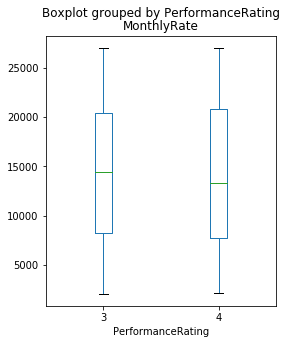

In [10]:
df.boxplot('MonthlyRate', by = 'PerformanceRating', grid = False, figsize = (4,5))

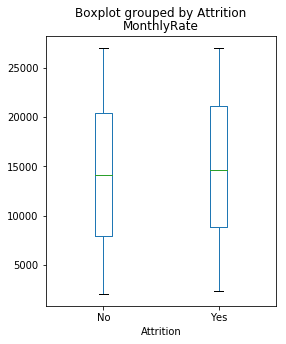

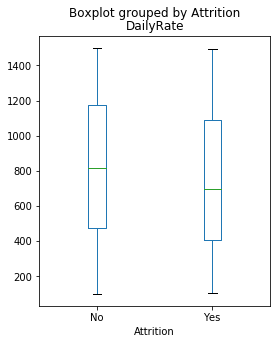

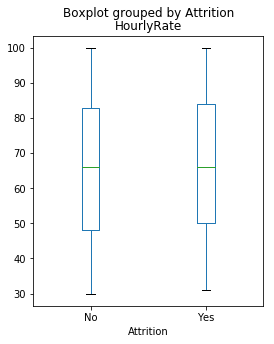

In [11]:
df.boxplot('MonthlyRate', by = 'Attrition', grid = False, figsize = (4,5))
df.boxplot('DailyRate', by = 'Attrition', grid = False, figsize = (4,5))
df.boxplot('HourlyRate', by = 'Attrition', grid = False, figsize = (4,5))

# MonthlyRate n'est pas significatif pour expliquer l'attrition, HourlyRate non plus, DailyRate un peu plus
# CONCLUSION: On va considérer que DailyRate est un indice de performance d'unité inconnue, et MonthlyRate NS - à éliminer


### EmployeeCount, EmployeeNumber, StandardHours & Over18

In [12]:
print(df['EmployeeCount'].unique()) # A supprimer : 1 partout
print(df['StandardHours'].unique()) # A supprimer : 80 pour tout le monde
print(df['EmployeeNumber'].describe()) # A supprimer : matricule de l'employé

print(df[df['Over18']== 'Y'].shape[0])
print(df[df['Over18']=='N'].shape[0]) # A supprimer : Yes pour tout le monde

[1]
[80]
count    1470.000000
mean     1024.865306
std       602.024335
min         1.000000
25%       491.250000
50%      1020.500000
75%      1555.750000
max      2068.000000
Name: EmployeeNumber, dtype: float64
1470
0


# Preprocessing - Etude de la population

Le but est ici de voir quel type de population, notamment pour les variables qualitatives

In [13]:
# Changement de certains noms de valeurs dans la base

df['Department'].replace(to_replace ='Research & Development', value = 'R&D', inplace = True)
df['Department'].replace(to_replace ='Human Resources', value = 'HR', inplace = True)
df['BusinessTravel'].replace(to_replace ='Travel_Rarely', value = 'Rarely', inplace = True)
df['BusinessTravel'].replace(to_replace ='Travel_Frequently', value = 'Frequently', inplace = True)

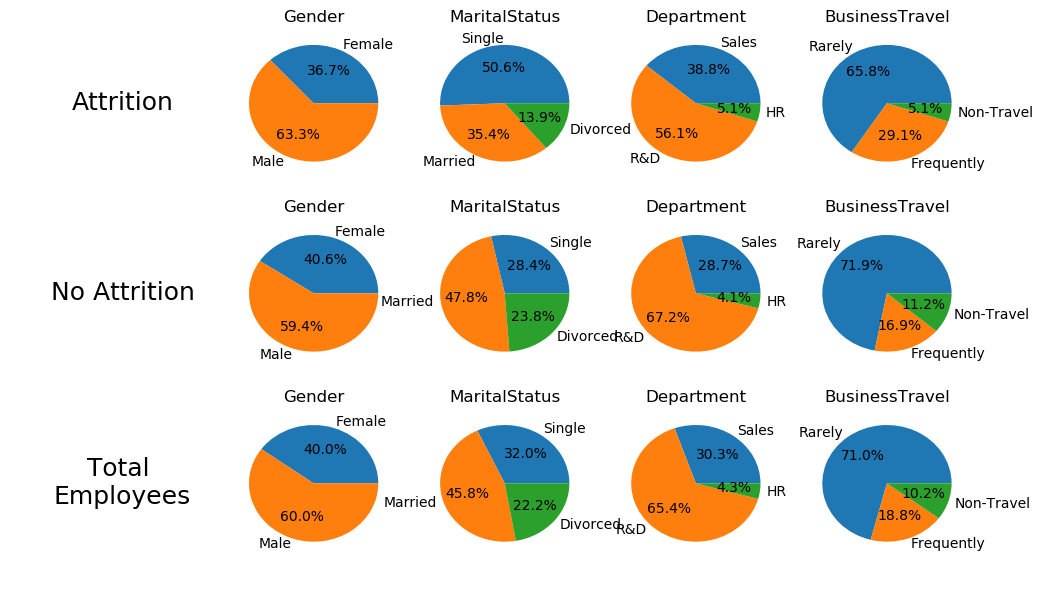

In [14]:
def titre(tlist,n):
    j = 0
    for i in n:
        plt.subplot(grid[i,0])
        plt.axis('off')
        plt.text(0.5,0.5, tlist[j] , ha='center', va='center', size = 18)
        j +=1
        
fig = plt.figure(figsize=(10,6), dpi=100)
grid = gridspec.GridSpec(3,5)
        
df0 = df[df['Attrition']=='Yes']
df1 = df[df['Attrition']=='No']
dA = [df0, df1, df]

titre(['Attrition', 'No Attrition', 'Total \nEmployees'],range(3))
var = ['Gender','MaritalStatus','Department','BusinessTravel']

j = 0
for d in dA:
    lab = list()
    k = 1
    for v in var:
        lab = df[v].unique()
        frac = list()
        for l in range(len(lab)):
            frac.append(d[d[v] == lab[l]].shape[0])
        plt.subplot(grid[j,k])
        plt.pie(frac, labels=lab, autopct='%1.1f%%')
        plt.title(v)
        k +=1
    j +=1

plt.tight_layout()
plt.show()  
    
# Le plus flagrant : les personnes célibataires sont plus susceptibles de partir que les personnes mariées
# les hommes ont un peu plus tendance à partir que les femmes
# le département le plus concerné par les départs est le département des Sales, ensuite les RH
# les personnes partant fréquemment en voyages d'affaire sont plus susceptibles de partir

_Analyse_

- Le plus flagrant : les personnes célibataires sont plus susceptibles de partir que les personnes mariées
- Les hommes ont un peu plus tendance à partir que les femmes
- Le département le plus concerné par les départs est le département des Sales, ensuite les RH
- Les personnes partant fréquemment en voyages d'affaire sont plus susceptibles de partir

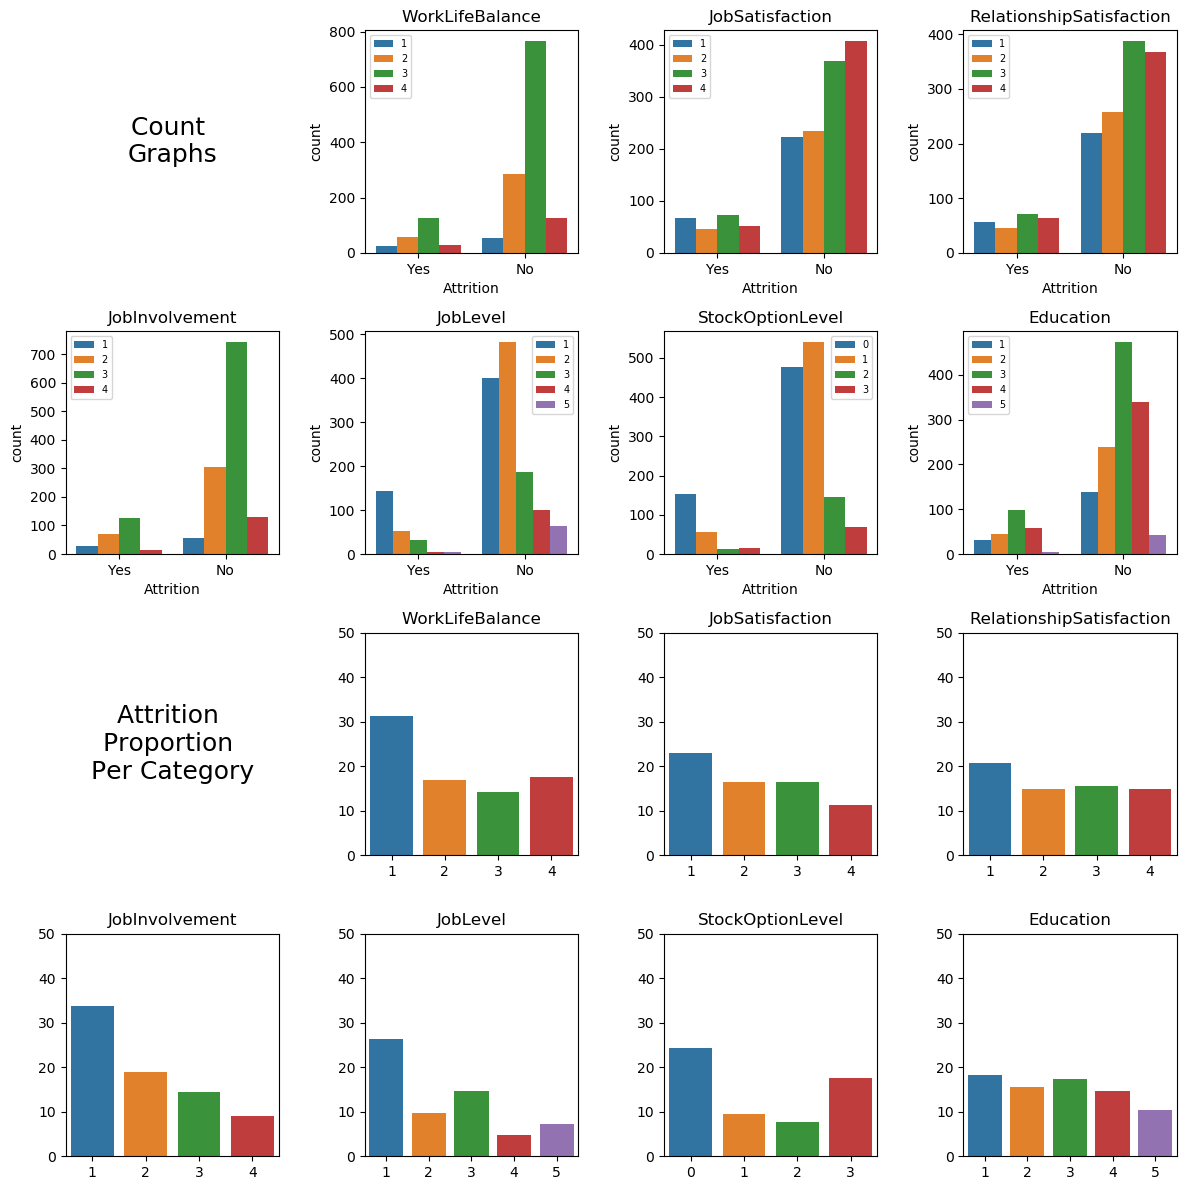

In [15]:
# Variables discrètes - diagrammes en bar

def prop_yes_category(c):
    result = pd.DataFrame()
    yes = df.groupby([c,'Attrition']).Attrition.count().reset_index(name ='Count').sort_values([c])
    tot = yes.groupby([c]).agg({'Count':np.sum}).reset_index().sort_values([c])
    yes = yes[yes['Attrition'] == 'Yes']
    result = [i/j*100 for i,j in zip(yes['Count'], tot['Count'])]
    return(result) 

def plot_prop(c):
    prop = prop_yes_category(c)
    n = sorted(df[c].unique())
    sns.barplot(x = n, y = prop)
    plt.title(c)
    plt.ylim([0,50])

fig = plt.figure(figsize=(12,12), dpi=100)
grid = gridspec.GridSpec(4,4)

titre(['Count \nGraphs','Attrition \nProportion \nPer Category'], [0,2])
col = ['WorkLifeBalance','JobSatisfaction', 'RelationshipSatisfaction','JobInvolvement', 'JobLevel', 'StockOptionLevel', 'Education']

i = 1
j = 0
for c in col:
    if i in range(1,4):
        plt.subplot(grid[0,i])
        sns.countplot(x= 'Attrition', hue = c, data= df)
        plt.title(c)
        plt.legend(prop={'size':7})
        
        plt.subplot(grid[2,i])
        plot_prop(c)
        i +=1
        
    else:
        plt.subplot(grid[1,j])
        sns.countplot(x= 'Attrition', hue = c, data= df)
        plt.title(c)
        plt.legend(prop={'size':7})
           
        plt.subplot(grid[3,j])
        plot_prop(c)
        j +=1

plt.tight_layout()
plt.show()

_Analyse_

- Comme pressenti, les personnes ayant répondu le plus négativement au questionnaire partent proportionnellement plus que les autres (c'est surtout très clair pour les questions WorkLifeBalance et JobInvolvement)
- Les personnes ayant un niveau d'étude faible ont plus tendance à partir que les autres, mais la différence n'est vraiment pas significatif, c'est plus vrai pour les personnes étant en bas de la hiérarchie en termes de postes de travail
- Une surprise, la tranche d'employés possédant le plus de StockOptions a le deuxième taux d'attrition le plus élevé, l'impact de StockOptionLevel sur l'attrition n'apparait pas clairement.

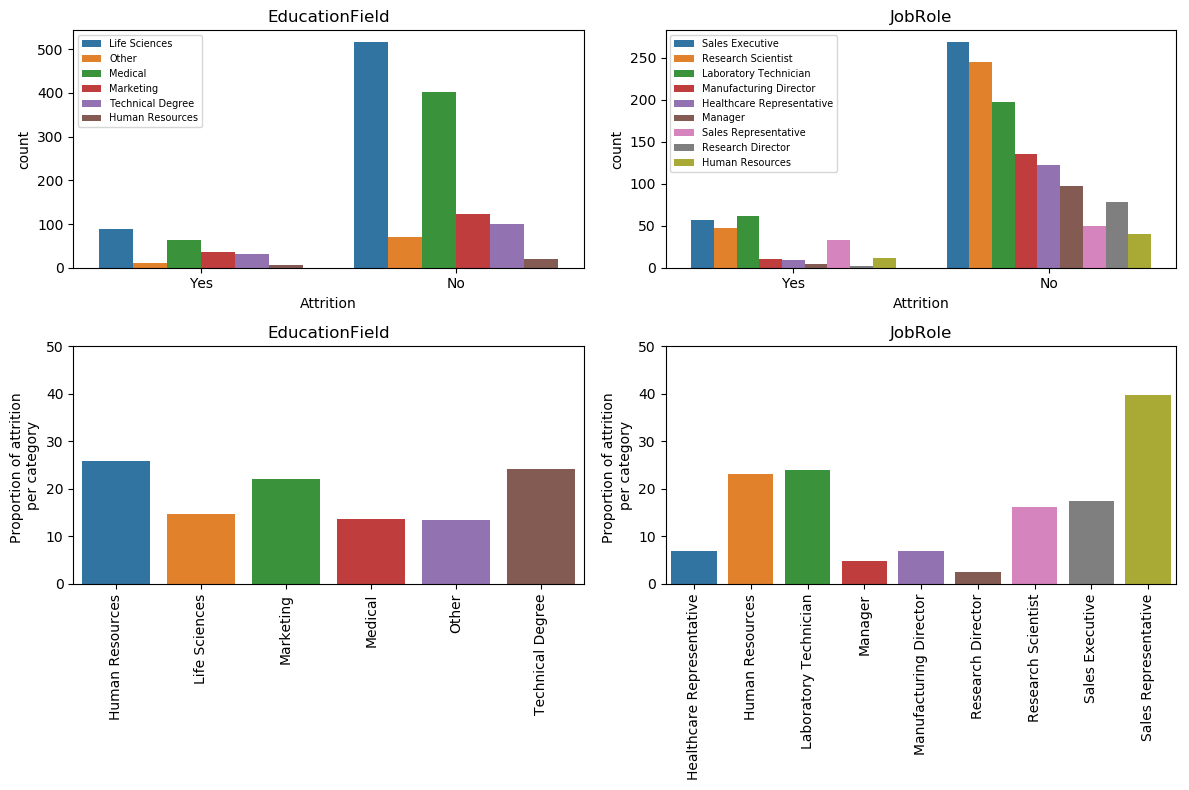

In [16]:
fig = plt.figure(figsize=(12,8), dpi=100)
grid = gridspec.GridSpec(2,2)

col = ['EducationField','JobRole']

i = 0
for c in col:
    plt.subplot(grid[0,i])
    sns.countplot(x= 'Attrition', hue = c, data= df)
    plt.title(c)
    plt.legend(prop={'size':7})
        
    plt.subplot(grid[1,i])
    plot_prop(c)
    plt.xticks(rotation=90)
    plt.ylabel('Proportion of attrition \nper category')
    i +=1
    
plt.tight_layout()
plt.show()

_Analyse_

- Le taux d'attrition n'est pas du tout le même en fonction du type de position dans l'entreprise. Les positions partant le plus sont les Sales Representatives (sûrement expliqué par la fréquence de voyages d'affaires)
- Les Managers et Directeurs sont ceux qui partent le moins.
- Les taux d'attrition diffèrent aussi en fonction du type d'études, mais c'est moins flagrant. Les personnes ayant étudié les Ressources Humaines sont paradoxalement ceux qui partent le plus, suivis par les ingénieurs/techniciens.

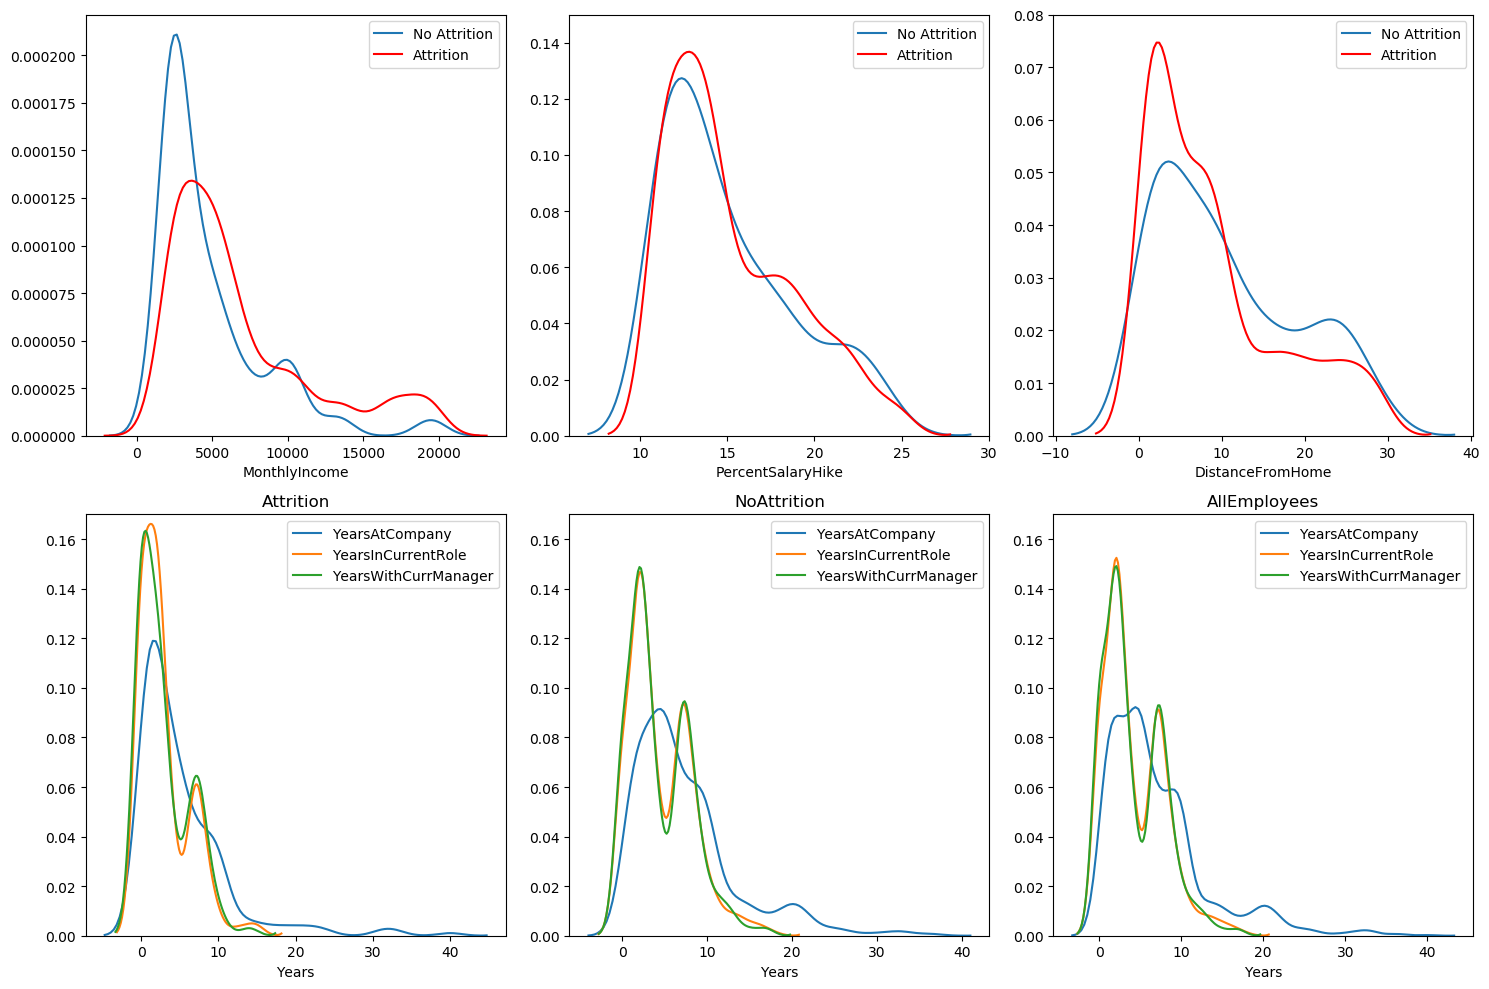

In [17]:
# Variables quantitatives

fig = plt.figure(figsize=(15,10), dpi=100)
grid = gridspec.GridSpec(2,3)

col = ['MonthlyIncome','PercentSalaryHike', 'DistanceFromHome']

i = 0
for c in col:
    plt.subplot(grid[0,i])
    sns.distplot(df0[c], hist = False, label = 'No Attrition')
    sns.distplot(df1[c], color = 'red', hist = False, label = 'Attrition')
    if i == 1:
        plt.ylim([0,0.15])
    elif i == 2:
        plt.ylim([0,0.08])
    i +=1

title = ['Attrition','NoAttrition','AllEmployees']
var = ['YearsAtCompany', 'YearsInCurrentRole', 'YearsWithCurrManager']
j = 0
for d in dA:
    plt.subplot(grid[1,j])
    for v in var:
        sns.distplot(d[v], hist = False, label = v)
        plt.legend(prop={'size':10}, loc=1)
        plt.ylim([0,0.17])
        plt.xlabel('Years')
        plt.title(title[j])
    j +=1

plt.tight_layout()
plt.show()

_Analyse_

- Les personnes partant de l'entreprise ont en moyenne un salaire plus élevé que ceux ne partant pas
- l'augmentation de salaire a un faible impact sur l'attrition, la distribution de l'augmentation de salaire est sensiblement la même dans les deux groupes
- L'Attrition est très forte pour un certain intervalle de distance, mais en dehors de cet intervalle, la distance n'influence plus beaucoup l'Attrition.
- On peut voir que dans les trois groupes Attrition, No Attrition, et All Employees, la distribution de YearsAtCompany et Years withCurrentManager est sensiblement la même, on va pouvoir supprimer une des deux variables pour éviter une redondance d'informations
- Dans le groupe Attrition, la distribution des 3 variables YearsAtCompany, YearsInCurrentRole, YearsWithCurrManager prends en moyenne des valeurs plus faibles que dans les deux autres groupes, les gens étant partis ont tendance à être dans l'entreprise depuis moins longtemps, et surtout a avoir moins changé de position (cf. plus faible différence entre courbe bleue et les autres dans le premier graphe)


In [18]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

# Préparation des données pour l'étude prédictive

Nous avons dû choisir un traitement pour nos variables catégoriques. Nous avons choisi de garder en variables continues les variables qui ont plus de quatre catégories et dont la moyenne fait sens (ex: les individus ont du noter leur JobSatisfaction sur une échelle allant de 1 à 4, 4 étant la meilleure note. Faire une moyenne sur cette variable fait bet et bien sens).

Il nous reste donc 7 variables catégoriques qu'il faut donc transformer toutes les variables catégoriques en colonnes indicatrices de catégories. 
Les variables sont : 
- EducationField
- JobRole
- BusinessTravel
- Gender   
- OverTime
- MaritalStatus 
- Department 

### Traitement des variables catégoriques

In [19]:
var_cat = ['EducationField', 'JobRole', 'BusinessTravel','MaritalStatus', 'Department' ]
var_bin = ['Gender','OverTime','Attrition']
df1 = pd.DataFrame(index= range(df.shape[0]))
for var in var_cat:
    liste_cat='var'+'_'+var
    liste_cat = pd.get_dummies(df[var], prefix=var)
    df1= df1.merge(liste_cat, left_index= True, right_index=True )
    
for var in var_bin:
    liste_cat='var'+'_'+var
    liste_cat = pd.get_dummies(df[var], prefix=var, drop_first= True )
    df1= df1.merge(liste_cat, left_index= True, right_index=True )
    
df1.head()

,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,...,BusinessTravel_Rarely,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Department_HR,Department_R&D,Department_Sales,Gender_Male,OverTime_Yes,Attrition_Yes
0,0,1,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,1,1
1,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0
2,0,0,0,0,1,0,0,0,1,0,...,1,0,0,1,0,1,0,1,1,1
3,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
4,0,0,0,1,0,0,0,0,1,0,...,1,0,1,0,0,1,0,1,0,0


In [20]:
dfc = df.merge(df1, left_index= True, right_index=True )
dfc = dfc.drop([var for var in var_cat], 1)
dfc = dfc.drop([var for var in var_bin], 1)
dfc = dfc.drop(['EmployeeCount', 'StandardHours', 'EmployeeNumber', 'Over18'], 1) 
dfc.columns

Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'EducationField_Human Resources', 'EducationField_Life Sciences',
       'EducationField_Marketing', 'EducationField_Medical',
       'EducationField_Other', 'EducationField_Technical Degree',
       'JobRole_Healthcare Representative', 'JobRole_Human Resources',
       'JobRole_Laboratory Technician', 'JobRole_Manager',
       'JobRole_Manufacturing Director', 'JobRole_Research Director',
       'JobRole_Research Scientist', 'JobRole_Sales Executive',
       'JobRole_Sales Representative', 'Busi

# Modèle Selection

## Variables corrélées:

Nous allons étudier la corrélation des variables et supprimer les variables qui sont très corrélées afin de ne pas fausser notre modèle. 

Voici les coefficients de corrélation entre nos variables, au dessus d'un certain seuil - ici 0.65.


In [21]:
X = dfc.drop('Attrition_Yes', 1)
y = dfc['Attrition_Yes']

In [22]:
def correlation_table(X, limit):
    corr = pd.DataFrame(columns = ['Variable 1', 'Variable 2', 'Coefficient de Correlation'])
    i = 0
    n = len(X.columns)
    for j in range(n):
        for k in range(j+1,n):
            coef = np.corrcoef(X.iloc[:,j], X.iloc[:,k])[0,1]
            if abs(coef) > limit:
                corr.loc[i] = [X.columns[j], X.columns[k] ,coef]
                i +=1
    return(corr)

correlation_table(X, 0.65)

,Variable 1,Variable 2,Coefficient de Correlation
0,Age,TotalWorkingYears,0.680381
1,JobLevel,MonthlyIncome,0.950300
2,JobLevel,TotalWorkingYears,0.782208
3,MonthlyIncome,TotalWorkingYears,0.772893
4,PercentSalaryHike,PerformanceRating,0.773550
5,YearsAtCompany,YearsInCurrentRole,0.758754
6,YearsAtCompany,YearsWithCurrManager,0.769212
7,YearsInCurrentRole,YearsWithCurrManager,0.714365
8,JobRole_Human Resources,Department_HR,0.904983
9,JobRole_Sales Executive,Department_R&D,-0.733497


Afin de choisir pertinemment quelle variable garder regardons la corrélation avec la variable "Attrition". Ici H0 de notre test est: les moyennes de nos variables sont les mêmes pour une attrition égale à 1 ou 0. 

In [23]:
# 2-Sample t-test (mean comparison):

var = [['Age', 'TotalWorkingYears','JobLevel', 'MonthlyIncome'],['PercentSalaryHike', 'PerformanceRating'], ['YearsAtCompany', 'YearsInCurrentRole', 'YearsWithCurrManager'] ]

def pval_ttest(var):
    pval = pd.DataFrame(columns = ['Var','pval_CorrelationWithAttrition'])
    i = 0
    for j in range(len(var)):
        for v in var[j]:
            a = dfc[dfc['Attrition_Yes']==1][v]
            b = dfc[dfc['Attrition_Yes']==0][v]
            if np.var(a) == np.var(b):
                p = stats.ttest_ind(a,b, equal_var = True)[1]
            else:
                p = stats.ttest_ind(a,b, equal_var = False)[1]
            pval.loc[i] = [v,p]
            i+=1
    return(pval)

pval_ttest(var)

,Var,pval_CorrelationWithAttrition
0,Age,1.379760e-08
1,TotalWorkingYears,1.159817e-11
2,JobLevel,9.844803e-13
3,MonthlyIncome,4.433589e-13
4,PercentSalaryHike,6.144301e-01
5,PerformanceRating,9.124808e-01
6,YearsAtCompany,2.285905e-07
7,YearsInCurrentRole,3.187390e-11
8,YearsWithCurrManager,1.185022e-10


Nous avons des groupements de variables qui sont très corrélées, comme le groupe 'Age', 'TotalWorkingyears', 'JobLevel' et 'Monthly Income'. 
JobLevel et MonthlyIncome sont très corrélé (plus de 0.95 de corrélation), alors nous allons supprimer JobLevel qui est une échelle de 1 à 5 au profit de MonthlyIncome qui est plus continu. De même TotalWorkingYears est très corrélé à MonthlyIncome (0.77) donc nous allons aussi le supprimer. Mais nous allons conserver la variable 'Age' parce qu'elle n'est pas tant corrélé au MonthlyIncome (0.5), on perderait de l'information. 

Dans le groupe 'PercentSalaryHike' vs. 'PerformanceRating': On supprime PerformanceRating une variable discrète au profit d'une variable plus continue.

Dans le grouepement : 'YearsAtCompany' vs. 'YearsInCurrentRole' vs. 'YearWithCurrManager': On supprime YearsAtCompany & YearsWithCurrManager, en raison de la p-value plus petite de 'YearsInCurrentRole'.

Dans le groupe 'JobRole' vs. 'Department' (2 catégories corrélées 2 à 2): On supprime Department car perte d'information lié au nombre de catégories.

In [24]:
X = X.drop(['TotalWorkingYears','JobLevel','PerformanceRating','YearsAtCompany','YearsWithCurrManager','Department_HR','Department_R&D','Department_Sales'],1)
X.columns

Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement',
       'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'RelationshipSatisfaction', 'StockOptionLevel',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'EducationField_Human Resources',
       'EducationField_Life Sciences', 'EducationField_Marketing',
       'EducationField_Medical', 'EducationField_Other',
       'EducationField_Technical Degree', 'JobRole_Healthcare Representative',
       'JobRole_Human Resources', 'JobRole_Laboratory Technician',
       'JobRole_Manager', 'JobRole_Manufacturing Director',
       'JobRole_Research Director', 'JobRole_Research Scientist',
       'JobRole_Sales Executive', 'JobRole_Sales Representative',
       'BusinessTravel_Frequently', 'BusinessTravel_Non-Travel',
       'BusinessTravel_Rarely', 'MaritalStatus_Div

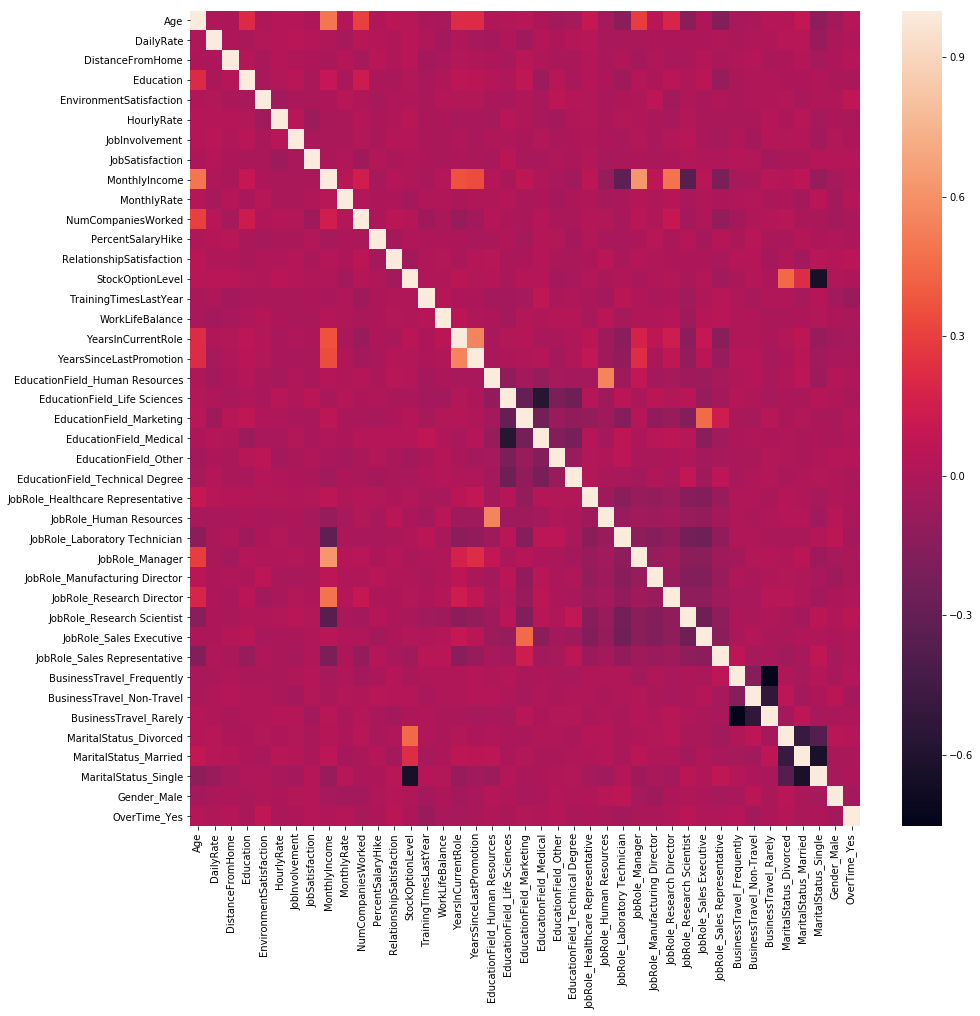

In [25]:
# Matrice de corrélation sur les variables X pour ne pas ajouter de 'poids' à une des features

fig2,ax2 = plt.subplots(figsize=(15, 15))
sns.heatmap(X.corr(), annot = False)

## Backwards regression

Nous allons procéder à une backwards logistic regression, c'est à dire que nous allons mettre toutes les variables dans notre modèle, puis éliminer grâce aux p-values, les variables qui ne sont pas significatives pour la prédiction de l'attrition.

In [26]:
# Cell pour réinitialiser la suppression de variables si besoin

X = dfc.drop('Attrition_Yes', 1)
X = X.drop(['TotalWorkingYears','JobLevel','PerformanceRating','YearsAtCompany','YearsWithCurrManager','Department_HR','Department_R&D','Department_Sales'],1)
X = smt.add_constant(X, prepend = True)
y = dfc['Attrition_Yes']

In [27]:
# première regression logistique avec toutes nos variables: 
def smlogit_result(y,X):
    logit_model=sm.Logit(y,X)
    result=logit_model.fit(maxiter=500)
    return(result)

smlogit_result(y,X).summary()

Optimization terminated successfully.
         Current function value: inf
         Iterations 10


C:\Users\mlava\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1214: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\mlava\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1264: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\mlava\Anaconda3\lib\site-packages\statsmodels\base\model.py:1029: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
C:\Users\mlava\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\mlava\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\mlava\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in le

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Attrition_Yes   No. Observations:                 1470
Model:                          Logit   Df Residuals:                     1432
Method:                           MLE   Df Model:                           37
Date:                Sun, 14 Jan 2018   Pseudo R-squ.:                    -inf
Time:                        15:54:43   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                   -5.1895e+05
                                        LLR p-value:                     1.000
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                 2.1447        nan        nan        nan         nan         nan
Age                                  -0.0441      0.012     -3.631      0.000      -0.068      -0.020
DailyRate                            -0.0003      0.000     -1.281      0.200      -0.001       0.000
DistanceFromHome                      0.0436      0.011      4.108      0.000       0.023       0.064
Education                             0.0025      0.087      0.029      0.977      -0.168       0.173
EnvironmentSatisfaction              -0.4106      0.081     -5.038      0.000      -0.570      -0.251
HourlyRate                            0.0014      0.004      0.332      0.740      -0.007       0.010
JobInvolvement                       -0.5514      0.120     -4.583      0.000      -0.787      -0.316
JobSatisfaction                      -0.3935      0.080     -4.914      0.000      -0.550      -0.237
MonthlyIncome                     -4.118e-05   5.18e-05     -0.795      0.427      -0.000    6.03e-05
MonthlyRate                        5.266e-06   1.23e-05      0.426      0.670   -1.89e-05    2.95e-05
NumCompaniesWorked                    0.1731      0.037      4.687      0.000       0.101       0.246
PercentSalaryHike                    -0.0141      0.024     -0.577      0.564      -0.062       0.034
RelationshipSatisfaction             -0.2426      0.081     -2.979      0.003      -0.402      -0.083
StockOptionLevel                     -0.2106      0.156     -1.349      0.177      -0.517       0.095
TrainingTimesLastYear                -0.1789      0.072     -2.470      0.014      -0.321      -0.037
WorkLifeBalance                      -0.3535      0.122     -2.888      0.004      -0.593      -0.114
YearsInCurrentRole                   -0.1631      0.036     -4.485      0.000      -0.234      -0.092
YearsSinceLastPromotion               0.1711      0.037      4.573      0.000       0.098       0.244
EducationField_Human Resources        0.6322        nan        nan        nan         nan         nan
EducationField_Life Sciences          0.0967        nan        nan        nan         nan         nan
EducationField_Marketing              0.5159        nan        nan        nan         nan         nan
EducationField_Medical               -0.0036        nan        nan        nan         nan         nan
EducationField_Other                 -0.0818        nan        nan        nan         nan         nan
EducationField_Technical Degree       0.9599        nan        nan        nan         nan         nan
JobRole_Healthcare Representative    -0.5069        nan        nan        nan         nan         nan
JobRole_Human Resources               0.9609        nan        nan        nan         nan         nan
JobRole_Laboratory Technician         1.0385        nan        nan        nan         nan         nan
JobRole_Manager                      -0.0366        nan        nan        nan  

In [28]:
# Suppression de variables

pval_limit = 0.05
result = smlogit_result(y,X)
while  result.pvalues.max() > pval_limit:
    var_p_max = result.pvalues.argmax()
    if '_' in var_p_max: 
        var_cat = var_p_max.split('_')[0]
        var_cat_col = [i for i in list(X.columns.values) if var_cat in i]
        X = X.drop(var_cat_col, 1)
        print('Variable supprimée:' +'\033[1m' + var_cat + '\033[0m')
    else: 
        X = X.drop(var_p_max, 1)
        print('Variable supprimée: ' +'\033[1m' + var_p_max + '\033[0m')
    result = smlogit_result(y,X)
    
result.summary()

C:\Users\mlava\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1214: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\mlava\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1264: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\mlava\Anaconda3\lib\site-packages\statsmodels\base\model.py:1029: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
C:\Users\mlava\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\mlava\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\mlava\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in le

Optimization terminated successfully.
         Current function value: inf
         Iterations 10
Variable supprimée: Education
Optimization terminated successfully.
         Current function value: inf
         Iterations 10
Variable supprimée:MaritalStatus
Optimization terminated successfully.
         Current function value: inf
         Iterations 8
Variable supprimée:EducationField
Optimization terminated successfully.
         Current function value: inf
         Iterations 8
Variable supprimée: const
Optimization terminated successfully.
         Current function value: inf
         Iterations 8
Variable supprimée:JobRole
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Variable supprimée: HourlyRate
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Variable supprimée: MonthlyRate
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
Variable 

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Attrition_Yes   No. Observations:                 1470
Model:                          Logit   Df Residuals:                     1452
Method:                           MLE   Df Model:                           17
Date:                Sun, 14 Jan 2018   Pseudo R-squ.:                    -inf
Time:                        15:54:43   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                   -5.1895e+05
                                        LLR p-value:                     1.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Age                          -0.0489      0.011     -4.278      0.000      -0.071      -0.026
DistanceFromHome              0.0392      0.010      3.894      0.000       0.019       0.059
EnvironmentSatisfaction      -0.3738      0.076     -4.893      0.000      -0.524      -0.224
JobInvolvement               -0.5774      0.115     -5.019      0.000      -0.803      -0.352
JobSatisfaction              -0.3675      0.075     -4.872      0.000      -0.515      -0.220
MonthlyIncome                -0.0001   2.86e-05     -4.063      0.000      -0.000   -6.02e-05
NumCompaniesWorked            0.1560      0.034      4.547      0.000       0.089       0.223
RelationshipSatisfaction     -0.2338      0.078     -3.008      0.003      -0.386      -0.081
StockOptionLevel             -0.5762      0.111     -5.206      0.000      -0.793      -0.359
TrainingTimesLastYear        -0.1357      0.068     -1.994      0.046      -0.269      -0.002
WorkLifeBalance              -0.2268      0.114     -1.994      0.046      -0.450      -0.004
YearsInCurrentRole           -0.1610      0.034     -4.714      0.000      -0.228      -0.094
YearsSinceLastPromotion       0.1593      0.035      4.541      0.000       0.091       0.228
BusinessTravel_Frequently     5.4469      0.744      7.317      0.000       3.988       6.906
BusinessTravel_Non-Travel     3.6487      0.771      4.732      0.000       2.137       5.160
BusinessTravel_Rarely         4.6279      0.711      6.507      0.000       3.234       6.022
Gender_Male                   0.3810      0.173      2.200      0.028       0.042       0.720
OverTime_Yes                  1.7384      0.177      9.835      0.000       1.392       2.085
=============================================================================================
"""

### Comparaison des deux modèles de Regression Logistique

In [29]:
# Regression Logistique de Scikit learn:
# Sans intercept car const a été supprimée dans la backward regression

logreg = LogisticRegression(random_state = 0, fit_intercept = False ) #  seed utilisé par le random number generator
res_log = logreg.fit(X,y)

n = len(res_log.coef_[0])
var = pd.DataFrame(np.array(X.columns).reshape(n,1), columns = ['Variables'])
coef1 = pd.DataFrame(np.array(result.params), columns = ['Coef statsmodels'])
coef2 = pd.DataFrame(res_log.coef_[0].reshape(n,1), columns = ['Coef sklearn'])
coefs = pd.merge(coef1,coef2, right_index = True, left_index = True).reset_index(drop = True)
CoefLog = pd.merge(var,coefs, right_index = True, left_index = True)
CoefLog['Différence'] = CoefLog['Coef statsmodels'] - CoefLog['Coef sklearn']

print(CoefLog)

                    Variables  Coef statsmodels  Coef sklearn  Différence
0                         Age         -0.048874     -0.016562   -0.032312
1            DistanceFromHome          0.039236      0.042309   -0.003073
2     EnvironmentSatisfaction         -0.373790     -0.224053   -0.149736
3              JobInvolvement         -0.577421     -0.250886   -0.326535
4             JobSatisfaction         -0.367497     -0.194877   -0.172620
5               MonthlyIncome         -0.000116     -0.000119    0.000002
6          NumCompaniesWorked          0.155954      0.135969    0.019985
7    RelationshipSatisfaction         -0.233785     -0.113790   -0.119994
8            StockOptionLevel         -0.576238     -0.486691   -0.089547
9       TrainingTimesLastYear         -0.135659     -0.005348   -0.130312
10            WorkLifeBalance         -0.226827      0.103616   -0.330443
11         YearsInCurrentRole         -0.160974     -0.140195   -0.020779
12    YearsSinceLastPromotion         

In [30]:
rfe = RFE(logreg, 18)
rfe = rfe.fit(X, y )
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


# Modèles Prédictifs

In [31]:
dff = X.join(y)

In [42]:
# Séparation en un training_set et un test_set

train, test = train_test_split(dff, train_size=0.8, test_size = 0.2)
X_train = train.drop('Attrition_Yes', 1)
y_train = train['Attrition_Yes']
X_test = test.drop('Attrition_Yes', 1)
y_test = test['Attrition_Yes']

print(X_train.shape)
print(X_test.shape)

(1176, 18)
(294, 18)


## Dummy Classifier

Ce dummy classifier va nous servir de base pour les scores des prochains classifiers.

In [43]:
def dummy_classifier(y_train,y_test):
    n = len(y_test.index)
    prop = sum(y_train)/len(y_train.index) # proportion de 1 dans y_train
    if prop < 0.5:
        result = np.zeros((n,1))
    else:
        result = np.ones((n,1))
    return(result)

def accuracy(conf_matrix):
    tot = sum(sum(conf_matrix))
    acc = (conf_matrix[0,0]+conf_matrix[1,1])/tot
    return(acc)

y_dum_pred = dummy_classifier(y_train, y_test)
conf_matrix = confusion_matrix(y_test, y_dum_pred) # horizontal : predicted, vertical : True values 
print(conf_matrix)
print('Accuracy', accuracy(conf_matrix))

[[247   0]
 [ 47   0]]
Accuracy 0.840136054422


## Regressions Logistiques

Nous allons utiliser les deux modèles de statsmodels et sklearn

In [44]:
# SKLEARN régression sur la base X_train, y_train

res_log = logreg.fit(X_train, y_train)

# Prediction sur le training set

y_predlog = res_log.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_predlog)
y_score = res_log.score(X_test,y_test)

print(conf_matrix)
print('Accuracy', y_score)
print('Accuracy by hand', accuracy(conf_matrix))

[[244   3]
 [ 39   8]]
Accuracy 0.857142857143
Accuracy by hand 0.857142857143


In [45]:
# STATSMODELS regression

res_sm = smlogit_result(y_train,X_train)

# prediction sur le training set

y_predsm = res_sm.predict(X_test)
y_predsm = y_predsm.round()
conf_matrix = confusion_matrix(y_test, y_predsm)

print(conf_matrix)
print('Accuracy by hand', accuracy(conf_matrix))

Optimization terminated successfully.
         Current function value: inf
         Iterations 7
[[242   5]
 [ 31  16]]
Accuracy by hand 0.877551020408


C:\Users\mlava\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1214: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\mlava\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1264: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


## Support Vector Machine

In [46]:
# Linear Support Vector Machine

svm = LinearSVC(random_state = 0)
res_svm = svm.fit(X_train,y_train)

# Prediction

y_predsvm = res_svm.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_predsvm)
y_score_svm = res_svm.score(X_test,y_test)

print(conf_matrix)
print('Accuracy', y_score_svm)   
print('Accuracy by hand', accuracy(conf_matrix))

[[247   0]
 [ 47   0]]
Accuracy 0.840136054422
Accuracy by hand 0.840136054422


In [80]:
# plot SVM

n = len(res_svm.coef_[0])
var = pd.DataFrame(np.array(X.columns).reshape(n,1), columns = ['Variables'])
coef = pd.DataFrame(np.array(res_svm.coef_[0]), columns = ['Coef SVM'])
CoefSvm = pd.merge(var,coef, right_index = True, left_index = True)
Axis = np.array(CoefSvm.sort_values(by = ['Coef SVM'], ascending = False).head(2)['Variables'])

'NumCompaniesWorked'

In [ ]:
X0 = X_train[Axis[0]]
X1 = X_train[Axis[1]]
Z = 

plt.figure()
xx,yy = np.meshgrid(X0, X1)

plt.contourf()


## Comparaison des modèles

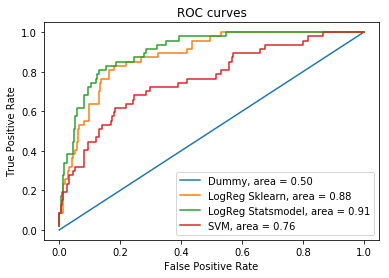

In [47]:
# Proportions pour le dummy_classifier, qui nous sert de base pour les autres modèles

prop = sum(y_train)/len(y_train.index)
dummy_prop = np.empty(len(y_test.index))
dummy_prop.fill(prop)

# ROC Curve

models = [dummy_prop, res_log.decision_function(X_test), res_sm.predict(X_test), res_svm.decision_function(X_test)]
titre = ['Dummy','LogReg Sklearn', 'LogReg Statsmodel', 'SVM']

plt.figure()
i = 0
for m in models:
    fpr,tpr,t = roc_curve(y_test,m)
    auc_ = auc(fpr,tpr)
    plt.plot(fpr, tpr, color = sns.color_palette()[i], label = titre[i] +', area = %0.02f' %auc_)
    i +=1
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves')
plt.legend(loc = 'lower right')
plt.show()